# Projeto - Machine Learning I
#### `Professor`: Alex Lima

Este documento descreve os requisitos e critérios de avaliação para projeto de Machine Learning I.

A principal finalidade deste projeto é fazer com o aluno pratique a exploração e modelagem de dados apresentados ao longo do modelo de machine learning I. Assim, durante o planejamento e desenvolvimento de seu projeto, recomenda-se visitar a ementa do módulo e mapear em seu projeto os itens previstos e lecionados em aula.

**DESAFIO**: Seu desafio neste módulo é conhecer uma área de negócio ou ciência de seu interesse e propor uma solução por meio de um modelo de machine learning. A solução deve ser apresentada prlo grupo no último dia de aula e detalhada em um report (jupyter notebook). Como referência, a equipe pode seguir os passos descritos a seguir:
 - `Introdução`
     > Descreva a área e a solução proposta em seu projeto
 - `Coleta de dados`
     > Busque ou construa um dataset relacionado ao problema que deseja solucionar.
 - `Desenvolvimento`
     > Desenvolva um modelo de machine learning, utilizando o algoritmo de sua escolha. Inclua métricas e visualizações que tornem seu modelo atrativo e compreensível para que não é da área de dados.
 - `Apresentação`
     > A apresentação deve ocorrer no último dia de aula (29/04). A equipe terá até 20 minutos para apresentar sua solução.
  
### Bons estudos! Sucesso!


####
# Problema de Negócio

O Banco Santander está com um novo produto em sua carteira de investimentos. 

A fim de obter um ROI (*return on investiment*) significativo nesta campanha, o diretor de vendas do Banco Santander, Alex Lima, pediu para a equipe de cientistas de dados do banco desenvolver um modelo preditivo que identifique entre seus potenciais clientes aqueles que possuem a maior probabilidade de fazer uma aplicação neste novo produto.

Desta forma, sua equipe de telemarketing poderá obter resultados muito eficientes e tirar sua corda do pescoço!

####
## Imports

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

from warnings import filterwarnings
filterwarnings("ignore")

####
## Funções para EDA

**Identidade visual**

In [2]:
colors = ["#d9ed92", "#b5e48c", "#99d98c", "#76c893", "#52b69a", "#34a0a4", "#168aad", "#1a759f", "#1e6091", "#184e77", "#123a59", "#0f304a"]
title_fontsize = 18
title_fontweight = 1000

**Plotagem de gráficos**

In [3]:
def pie_chart(data: pd.core.series.Series, labels: pd.core.series.Series, title: str, ax=None) -> None:
    """
    Esta função plota um gráfico de pizza.    

    Parâmetros:
    - `data`: recebe um objeto do tipo Série do Pandas, referente aos dados.
    - `labels`: recebe um objeto do tipo Série do Pandas, referente aos rótulos.
    - `title`: recebe uma string referente ao título do gráfico.
    """
    if not ax:    
        plt.figure(figsize=(6, 6))
        plt.title(title, fontsize=title_fontsize, fontweight=title_fontweight)
        ax = plt
    else:
        ax.set_title(title, fontsize=title_fontsize, fontweight=title_fontweight)

    ax.pie(
        data,
        explode=[0.1] + [0] * (len(data) - 1),
        labels=labels,
        colors=colors,
        autopct="%1.1f%%",
    )


def bar_chart(x: pd.core.series.Series, y: pd.core.series.Series, title: str, xlabel: str, ylabel: str, fmt: str, decimal=2, ax=None) -> None:
    """
    Esta função plota um gráfico de barra.    

    Parâmetros:
    - `data`: recebe um objeto do tipo Série do Pandas, referente aos dados.
    - `labels`: recebe um objeto do tipo Série do Pandas, referente aos rótulos.
    - `title`: recebe uma string referente ao título do gráfico.
    - `fmt`: recebe uma string referente ao símbolo da anotação acima da barra.
    - `decimal` (opcional, 2 por padrão): recebe um inteiro referente ao número de casas decimais da anotação acima da barra.
    - `ax` (opcional, None por padrão): recebe um eixo de subplot.
    """

    if not ax:    
        plt.figure(figsize=(8, 6))
        plt.title(title, fontsize=title_fontsize, fontweight=title_fontweight)  
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(rotation=45)
        ax = plt
    else:
        ax.set_title(title, fontsize=title_fontsize, fontweight=title_fontweight)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

        str_in_x = len(list(filter(lambda el: isinstance(el, str), x))) > 0
        xticks = np.arange(len(x)) if str_in_x else np.arange(min(x), max(x) + 1)
        labels = x if str_in_x else xticks
        ax.set_xticks(xticks, labels=labels, rotation=45)

    ax.bar(x, y, color=colors)
    ax.bar_label(ax.containers[0], label_type='edge', fmt=lambda num: f"{round(num, decimal)}{fmt}", fontsize=7, padding=2)

**Outras**

In [4]:
def features_freq_by_target(dataframe: pd.core.frame.DataFrame, target: str, *features: str, target_condition=None, normalize=True, sort_ascending=True) -> pd.core.frame.DataFrame:
    """
    Esta função retorna um dataframe contendo as frequências relativas de um grupo de features de um dataframe em relação a um target do mesmo dataframe.

    Parâmetros:
    - `dataframe`: recebe um objeto do tipo DataFrame do Pandas.
    - `target`: recebe uma string referente à coluna de target.
    - `features`: recebe uma ou mais strings indicando as colunas do DataFrame das quais se deseja obter as frequências em relação ao target.
    - `target_condition` (opcional, não definido por padrão): recebe uma string referente a um valor do target, a ser passado como filtro.
    - `normalize` (opcional, normalizado por padrão): recebe um valor booleano (True ou False) que define a normalização dos dados em porcentagem.
    - `sort_ascending` (opcional, ascendente por padrão): recebe um valor booleano (True ou False) que define a ordenação dos dados.
    """

    result = dataframe.groupby(list(features))[target].value_counts(normalize=normalize)
    if normalize:
        result *= 100
        
    result = result.sort_values(ascending=sort_ascending).reset_index()

    if target_condition:
        mask = result[target] == target_condition
        return result[mask].drop(target, axis=1)
    else:
        if normalize:
            return result

        result = result.groupby(list(features)).sum().sort_values(by="count", ascending=sort_ascending).reset_index()
        
        if len(features) > 1:
            return result
        else:
            return result.drop(target, axis=1)


def interval_presentation(age: pd._libs.interval.Interval) -> pd._libs.interval.Interval:
    """
    Esta função arredonda os intervalos e os formata para uma melhor apresentação visual.    

    Parâmetros:
    - `age`: recebe um objeto do tipo Intervalo do Pandas.
    """
    
    interval = pd.Interval(left=(round(age.left)), right=(round(age.right)))
    return f"{interval.left} a {interval.right}"

####
## Funções para cálculo das métricas

In [5]:
def classification_metrics(y_test: pd.core.series.Series, y_pred: np.ndarray) -> None:
    """
    Esta função imprime métricas para avaliação de modelos de classificação, como acurácia, precisão, revocação, F1-score e curva AUC.

    Parâmetros:
    - `y_test`: recebe um objeto do tipo Series do Pandas, referente aos dados de teste (y).
    - `y_pred`: recebe um objeto do tipo Array do NumPy, referente aos dados de previsão.
    """

    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    print(f"""
    AVALIAÇÃO DO MODELO - MÉTRICAS DE CLASSIFICAÇÃO
    ===============================================

    Acurácia:   {acc}
    Precisão:   {pre}
    Revocação:  {rec}
    F1-Score:   {f1}
    AUC:        {auc}
    """)


def confusion_mtx(y_test: pd.core.series.Series, y_pred: np.ndarray) -> None:
    """
    Esta função plota uma matriz de confusão para avaliação de modelos de classificação.

    Parâmetros:
    - `y_test`: recebe um objeto do tipo Series do Pandas, referente aos dados de teste (y).
    - `y_pred`: recebe um objeto do tipo Array do NumPy, referente aos dados de previsão.
    """

    conf_mtx = confusion_matrix(y_test, y_pred)

    sns.heatmap(conf_mtx, cmap="YlGnBu_r", annot=True, fmt="d")
    
    plt.title("Matriz de confusão", fontsize=16, fontweight=800, y=1.05)
    plt.ylabel("Real")
    plt.xlabel("Predito")
    
    plt.show()


def roc_auc(model: LogisticRegression, X_test: pd.core.frame.DataFrame, y_test: pd.core.series.Series, y_pred: np.ndarray) -> None:
    """
    Esta função plota um gráfico referente à curva ROC-AUC para avaliação de modelos de classificação.

    Parâmetros:
    - `model`: recebe um objeto do tipo LogisticRegression do scikit-learn, referente ao modelo de classificação.
    - `X_test`: recebe um objeto do tipo DataFrame do Pandas, referente aos dados de teste (X).
    - `y_test`: recebe um objeto do tipo Series do Pandas, referente aos dados de teste (y).
    - `y_pred`: recebe um objeto do tipo Array do NumPy, referente aos dados de previsão.
    """
    
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    reta = np.arange(0, 1.2, 0.2)

    plt.plot(reta, reta, linestyle="dashed")
    plt.plot(fpr, tpr, color="red")
    
    plt.margins(0, 0)
    plt.fill_between(fpr, tpr, color="#faf7cf")
    
    plt.title("Curva ROC-AUC", fontweight=800, fontsize=16, y=1.05)
    plt.xlabel("Taxa de falsos positivos")
    plt.ylabel("Taxa de verdadeiros positivos")
    plt.legend(["Chances aleatórias", "Curva ROC"])
    
    plt.show()

####
## Análise exploratória dos dados

### Análise inicial e remoção de outliers

In [6]:
df = pd.read_csv("bank-full.csv", delimiter=";")

In [7]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [8]:
df.shape

(45211, 17)

**Variáveis do dataset:**

1. `age`: idade
2. `job`: ocupação
3. `marital`: estado civil
4. `education`: nível educacional
5. `default`: possui débitos não quitados (inadimplência)
6. `balance`: saldo médio anual em euros
7. `housing`: possui empréstimo residencial
8. `loan`: possui empréstimo pessoal
9. `contact`: tipo de contato (meio de comunicação) da campanha
10. `day`: dia do mês do último contato da campanha
11. `month`: mês do último contato da campanha
12. `duration`: duração do último contato da campanha em segundos
13. `campaign`: quantidade de contatos realizados na última campanha para este cliente
14. `pdays`: quantidade de dias passados após o contato com o cliente em uma campanha anterior (-1 significa que o cliente não foi contatado anteriormente)
16. `previous`: quantidade de contatos realizados antes da atual campanha para este cliente
17. `poutcome`: resultado obtido em uma campanha de marketing anterior para este cliente
18. `y`: cliente aderiu à atual campanha

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [93]:
df.describe()

,age,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,y
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,2.060516,0.018027,1362.272058,0.555838,0.160226,15.806419,5.144655,258.163080,2.763841,40.197828,0.580323,0.116985
std,10.618762,0.778704,0.133049,3044.765829,0.496878,0.366820,8.322476,2.408034,257.527812,3.098021,100.128746,2.303441,0.321406
min,18.000000,0.000000,0.000000,-8019.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,2.000000,0.000000,72.000000,0.000000,0.000000,8.000000,4.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,2.000000,0.000000,448.000000,1.000000,0.000000,16.000000,5.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,3.000000,0.000000,1428.000000,1.000000,0.000000,21.000000,7.000000,319.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,3.000000,1.000000,102127.000000,1.000000,1.000000,31.000000,11.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


<Axes: >

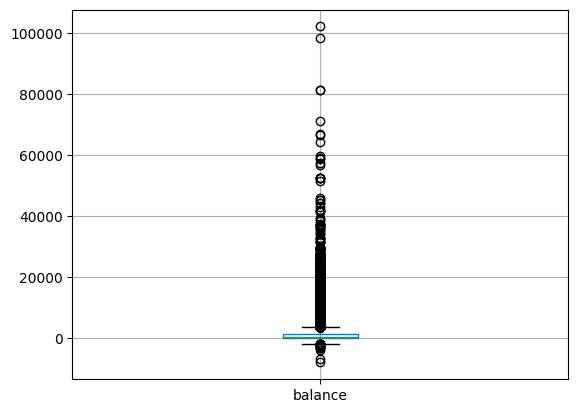

In [96]:
pd.DataFrame(df["balance"]).boxplot()

<Axes: >

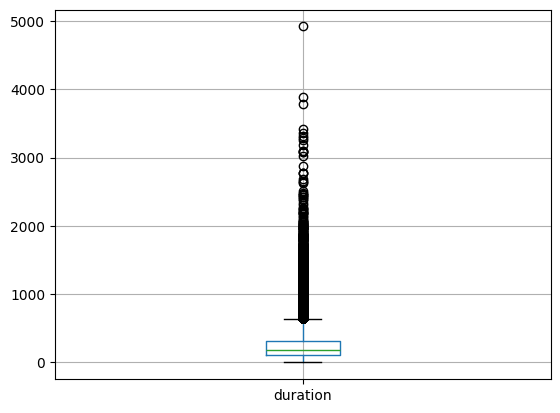

In [97]:
pd.DataFrame(df["duration"]).boxplot()

<Axes: >

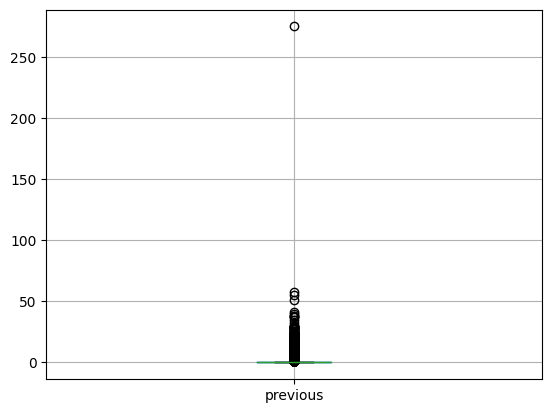

In [101]:
pd.DataFrame(df["previous"]).boxplot()

In [110]:
mask_outliers_balance = df["balance"] > 80000
mask_outliers_duration = df["duration"] > 4000
mask_outliers_previous = df["previous"] > 100

In [119]:
df = df[~(mask_outliers_balance | mask_outliers_duration | mask_outliers_previous)]

#####
### Relação entre features e target

**Convertidos por faixa de idade**

In [10]:
age_quantiles = pd.qcut(df["age"], 4).apply(interval_presentation)
ages_converted = features_freq_by_target(df, "y", age_quantiles, target_condition="yes", sort_ascending=False)
display(ages_converted)

,age,proportion
4,18 a 33,13.620729
5,48 a 95,13.282088
6,33 a 39,10.302559
7,39 a 48,9.023544


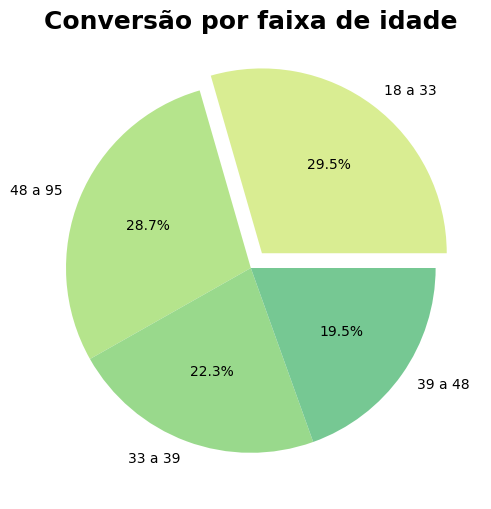

In [11]:
pie_chart(ages_converted["proportion"], ages_converted["age"], "Conversão por faixa de idade")

#####
**Convertidos por ocupação**

In [12]:
jobs_distribution = features_freq_by_target(df, "y", "job", normalize=False, sort_ascending=False)
display(jobs_distribution)

,job,count
0,blue-collar,9732
1,management,9458
2,technician,7597
3,admin.,5171
4,services,4154
5,retired,2264
6,self-employed,1579
7,entrepreneur,1487
8,unemployed,1303
9,housemaid,1240


In [13]:
jobs_converted = features_freq_by_target(df, "y", "job", target_condition="yes", sort_ascending=False)
display(jobs_converted)

,job,proportion
12,student,28.678038
13,retired,22.791519
14,unemployed,15.502686
15,management,13.755551
16,admin.,12.202669
17,self-employed,11.842939
18,unknown,11.805556
19,technician,11.056996
20,services,8.883004
21,housemaid,8.790323


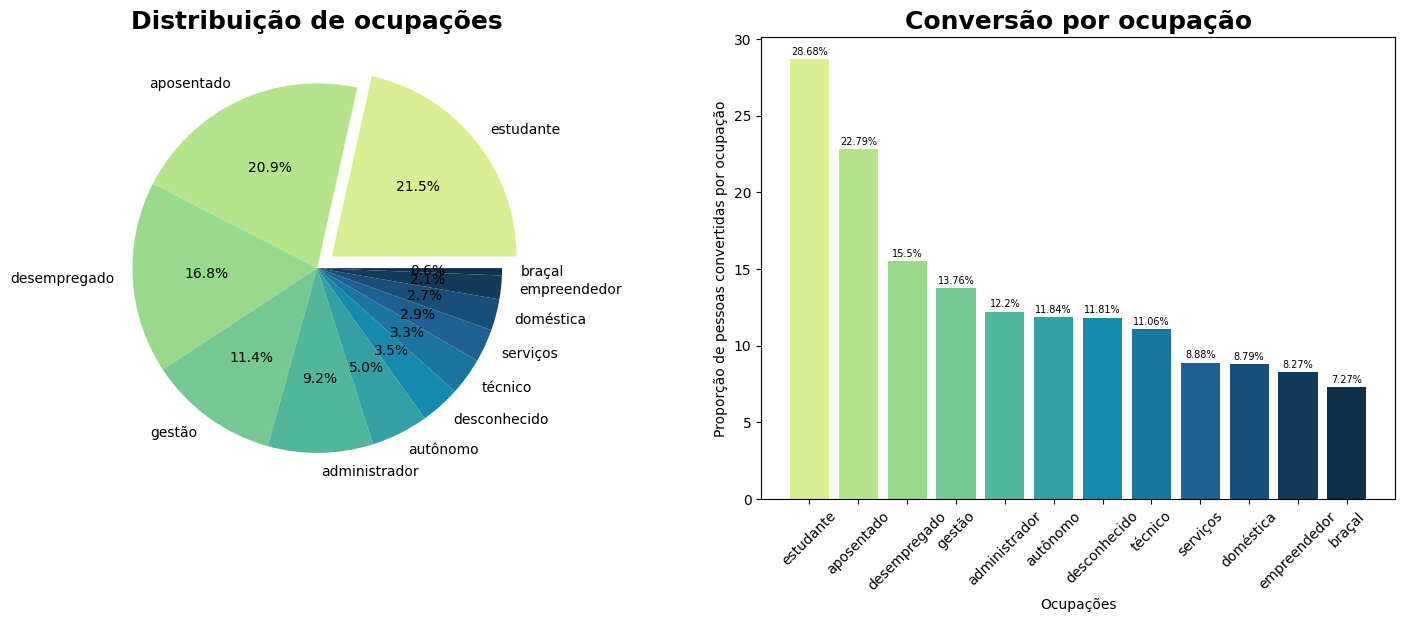

In [14]:
labels_translated = ["estudante", "aposentado", "desempregado", "gestão", "administrador",
                    "autônomo", "desconhecido", "técnico", "serviços", "doméstica", "empreendedor", "braçal"]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

pie_chart(
    jobs_distribution["count"], 
    labels_translated, 
    "Distribuição de ocupações", 
    ax=ax1
)

bar_chart(
    labels_translated, 
    jobs_converted["proportion"], 
    "Conversão por ocupação",
    "Ocupações",
    "Proporção de pessoas convertidas por ocupação",
    fmt="%", 
    ax=ax2
)

#####
**Convertidos por estado civil**

In [15]:
marital_status_converted = features_freq_by_target(df, "y", "marital", target_condition="yes", sort_ascending=False)
display(marital_status_converted)

,marital,proportion
3,single,14.949179
4,divorced,11.945458
5,married,10.123466


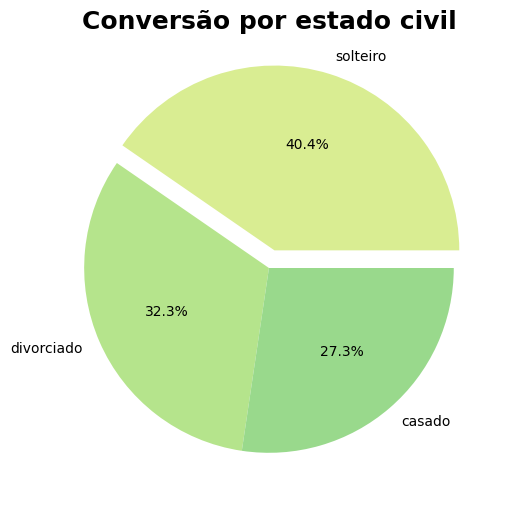

In [16]:
pie_chart(marital_status_converted["proportion"], ["solteiro", "divorciado", "casado"], "Conversão por estado civil")

#####
**Convertidos por nível educacional**

In [17]:
education_converted = features_freq_by_target(df, "y", "education", target_condition="yes", sort_ascending=False)
display(education_converted)

,education,proportion
4,tertiary,15.006390
5,unknown,13.570275
6,secondary,10.559435
7,primary,8.626478


In [18]:
education_balance_relation = features_freq_by_target(df, "balance", "education").groupby("education")["balance"].mean().sort_values(ascending=False).reset_index()
display(education_balance_relation)

,education,balance
0,tertiary,3499.189784
1,secondary,2967.395015
2,primary,2239.711616
3,unknown,1921.487402


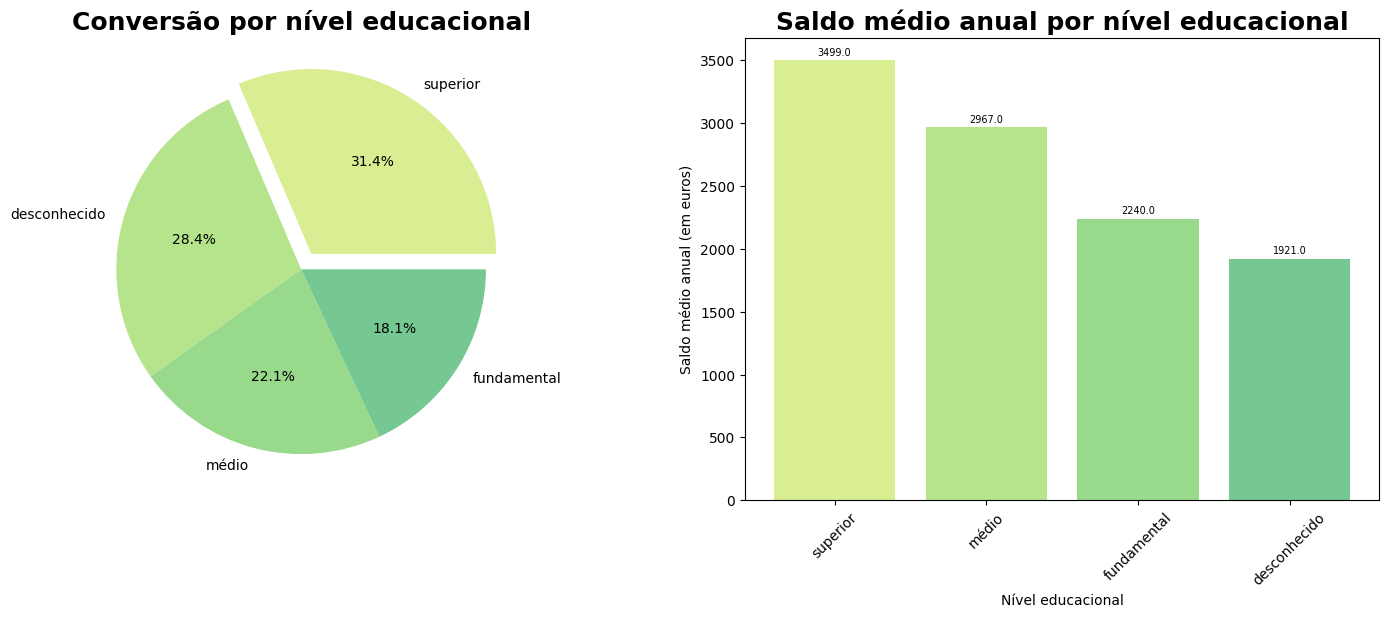

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

pie_chart(
    education_converted["proportion"], 
    ["superior", "desconhecido", "médio", "fundamental"], 
    "Conversão por nível educacional", 
    ax=ax1
)

bar_chart(
    ["superior", "médio", "fundamental", "desconhecido"], 
    education_balance_relation["balance"], 
    "Saldo médio anual por nível educacional", 
    "Nível educacional",
    "Saldo médio anual (em euros)",
    fmt="", 
    decimal=0, 
    ax=ax2
)

#####
**Convertidos por status de inadimplência**

In [20]:
default_converted = features_freq_by_target(df, "y", "default", target_condition="yes", sort_ascending=False)
display(default_converted)

,default,proportion
2,no,11.796108
3,yes,6.380368


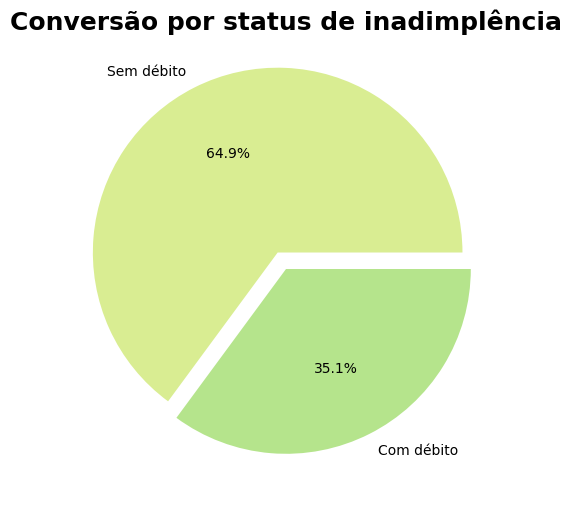

In [21]:
pie_chart(default_converted["proportion"], ["Sem débito", "Com débito"], "Conversão por status de inadimplência")

#####
**Convertidos por faixa de saldo**

In [22]:
balance_quantiles = pd.qcut(df["balance"], 4).apply(interval_presentation)
balance_converted = features_freq_by_target(df, "y", balance_quantiles, target_condition="yes", sort_ascending=False)
display(balance_converted)

,balance,proportion
4,1428 a 102127,16.154731
5,448 a 1428,12.515479
6,72 a 448,10.893632
7,-8019 a 72,7.236900


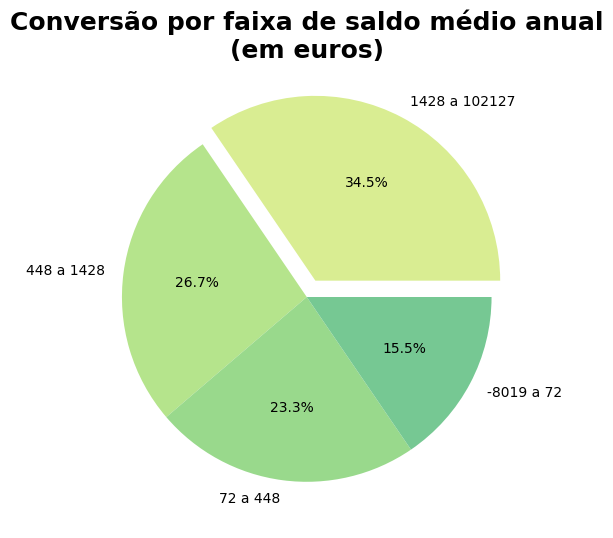

In [23]:
pie_chart(balance_converted["proportion"], balance_converted["balance"], "Conversão por faixa de saldo médio anual\n(em euros)")

#####
**Convertidos por empréstimos realizados**

In [24]:
housing_converted = features_freq_by_target(df, "y", "housing", target_condition="yes", sort_ascending=False)
display(housing_converted)

,housing,proportion
2,no,16.702355
3,yes,7.699960


In [25]:
loan_converted = features_freq_by_target(df, "y", "loan", target_condition="yes", sort_ascending=False)
display(loan_converted)

,loan,proportion
2,no,12.655727
3,yes,6.681391


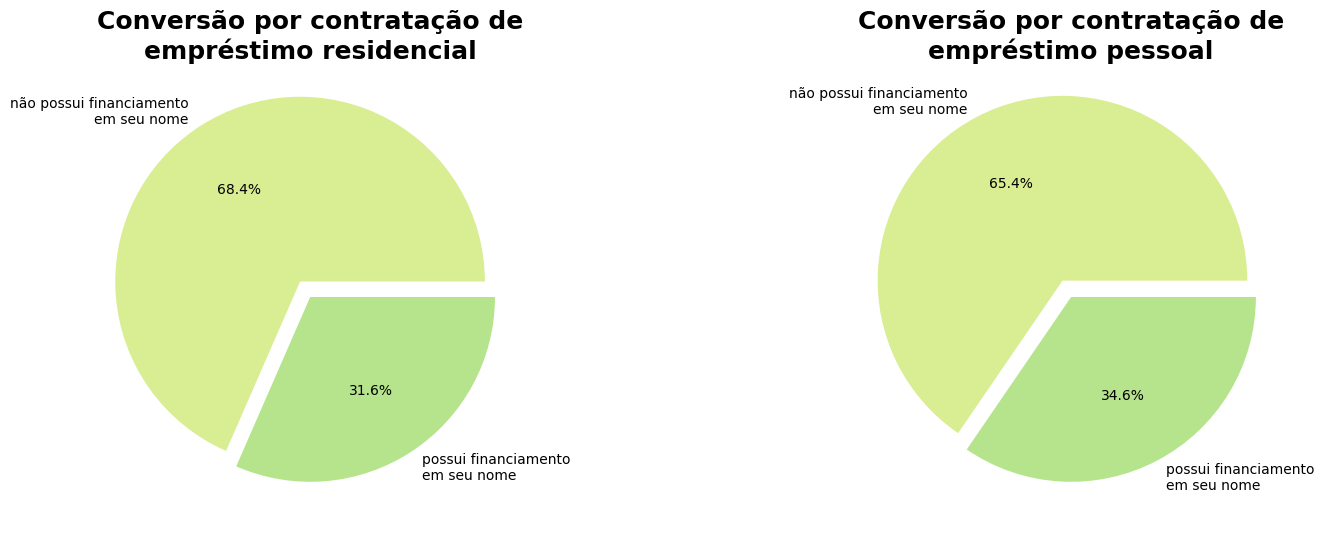

In [26]:
labels_translated = ["não possui financiamento\nem seu nome", "possui financiamento\nem seu nome"]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

pie_chart(
    housing_converted["proportion"], 
    labels_translated, 
    "Conversão por contratação de\nempréstimo residencial",
    ax=ax1
)

pie_chart(
    loan_converted["proportion"], 
    labels_translated, 
    "Conversão por contratação de\nempréstimo pessoal",
    ax=ax2
)

#####
**Convertidos por meio de contato**

In [27]:
contact_converted = features_freq_by_target(df, "y", "contact", target_condition="yes", sort_ascending=False)
display(contact_converted)

,contact,proportion
3,cellular,14.918900
4,telephone,13.420509
5,unknown,4.070661


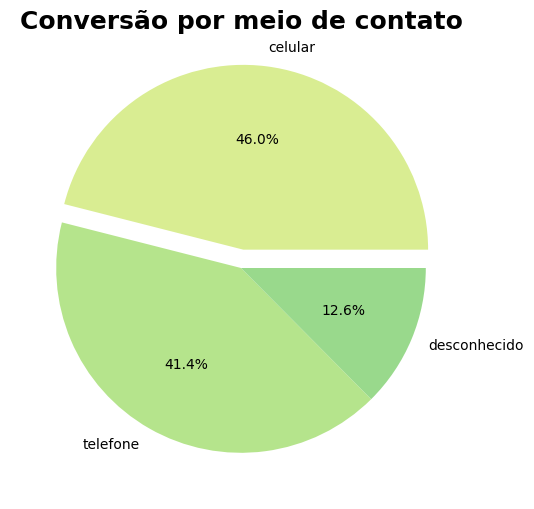

In [28]:
pie_chart(contact_converted["proportion"], ["celular", "telefone", "desconhecido"], "Conversão por meio de contato")

#####
**Convertidos por dia do mês**

In [29]:
day_converted = features_freq_by_target(df, "y", "day", target_condition="yes", sort_ascending=False).sort_values(by="day")
display(day_converted)

,day,proportion
31,1,27.950311
40,2,14.075793
35,3,16.496756
36,4,15.916955
49,5,11.256545
54,6,9.368530
56,7,8.640616
51,8,10.912052
47,9,11.467008
32,10,23.091603


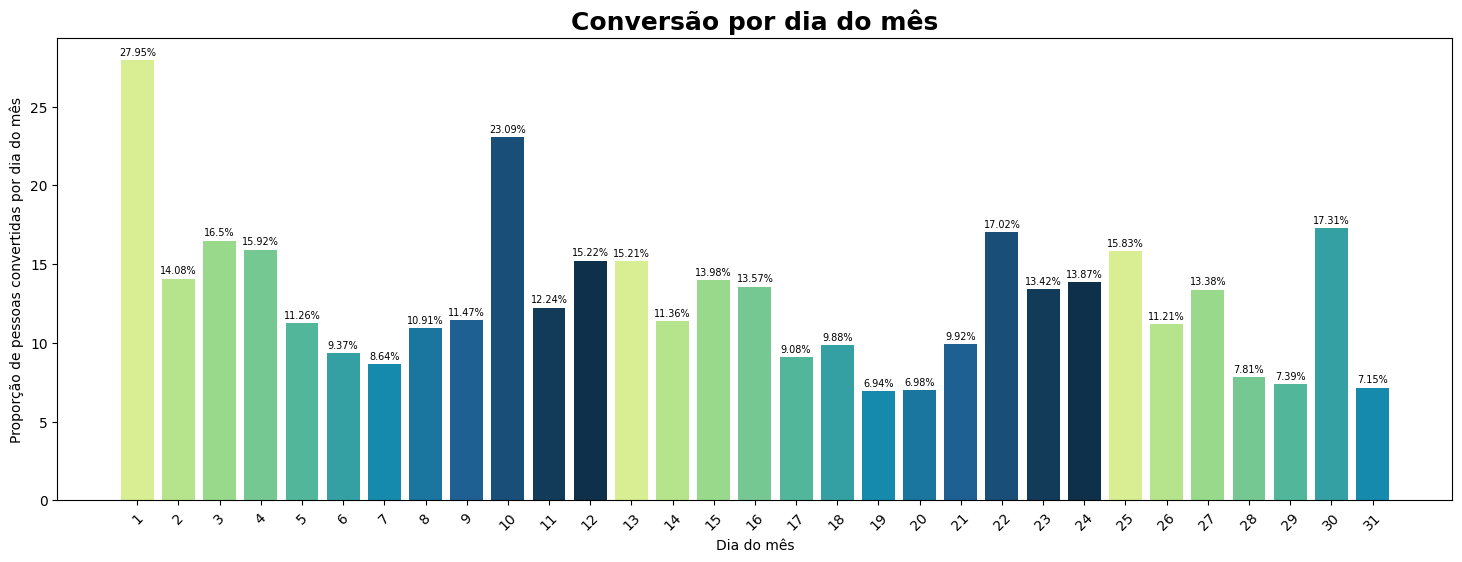

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))

bar_chart(
    day_converted["day"], 
    day_converted["proportion"], 
    "Conversão por dia do mês", 
    "Dia do mês",
    "Proporção de pessoas convertidas por dia do mês",
    fmt="%",
    ax=ax
)

#####
**Convertidos por mês**

In [31]:
months = {
    "jan": 0,
    "feb": 1,
    "mar": 2,
    "apr": 3,
    "may": 4,
    "jun": 5,
    "jul": 6,
    "aug": 7,
    "sep": 8,
    "oct": 9,
    "nov": 10,
    "dec": 11,
}
months_nums = df["month"].apply(lambda month: months[month])

month_converted = features_freq_by_target(df, "y", months_nums, target_condition="yes", sort_ascending=False).sort_values(by="month")
month_converted["month"] = month_converted["month"].apply(lambda i: list(months.keys())[i])
display(month_converted)

,month,proportion
21,jan,10.121169
17,feb,16.647792
11,mar,51.991614
16,apr,19.679400
23,may,6.719454
19,jun,10.222805
22,jul,9.093546
18,aug,11.013286
14,sep,46.459413
15,oct,43.766938


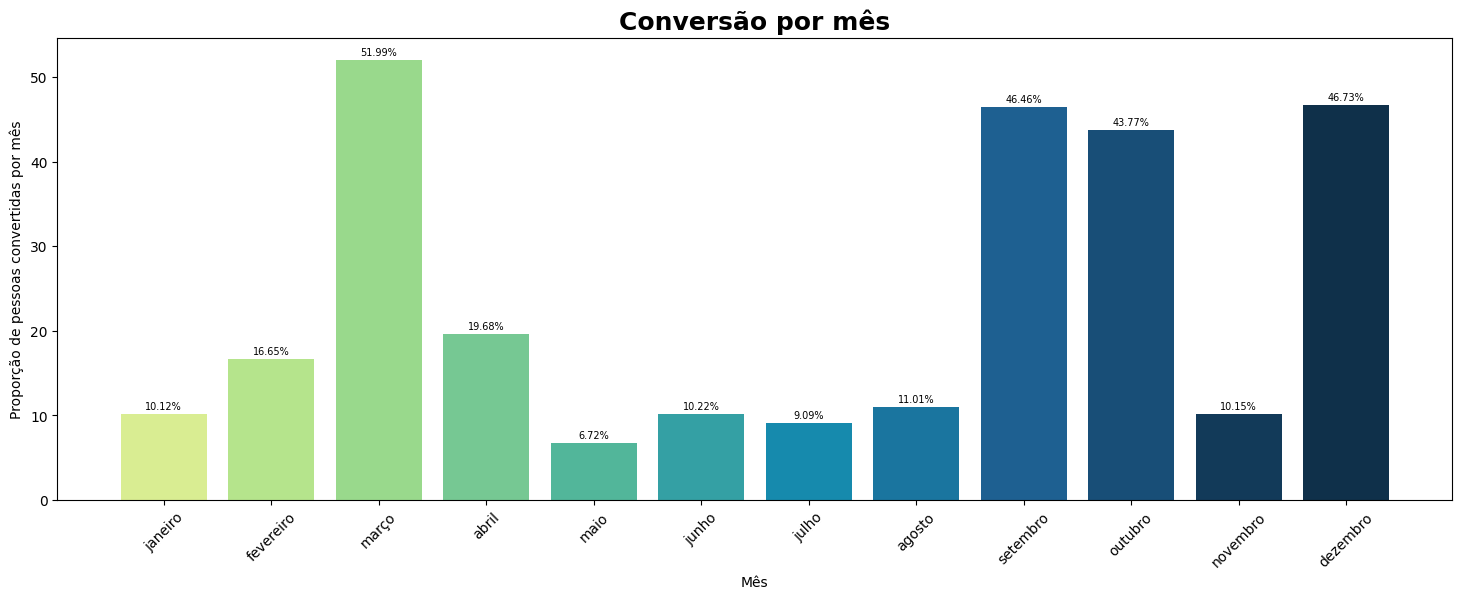

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))

bar_chart(
    ["janeiro", "fevereiro", "março", "abril", "maio", "junho", "julho", "agosto", "setembro", "outubro", "novembro", "dezembro"], 
    month_converted["proportion"], 
    "Conversão por mês", 
    "Mês",
    "Proporção de pessoas convertidas por mês",
    fmt="%",
    ax=ax
)

#####
**Convertidos por duração do contato**

In [33]:
duration_quantiles = pd.qcut(df["duration"], 4).apply(interval_presentation)
duration_converted = features_freq_by_target(df, "y", duration_quantiles, target_condition="yes", sort_ascending=False)
display(duration_converted)

,duration,proportion
4,319 a 4918,29.437883
5,180 a 319,11.204606
6,103 a 180,5.157288
7,0 a 103,1.116484


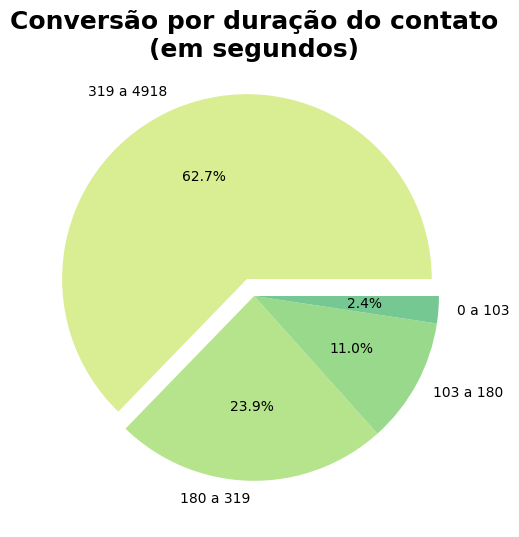

In [34]:
pie_chart(duration_converted["proportion"], duration_converted["duration"], "Conversão por duração do contato\n(em segundos)")

#####
**Convertidos por quantidade de ligações**

In [35]:
campaign_converted = features_freq_by_target(df, "y", "campaign", target_condition="yes", normalize=True, sort_ascending=False).sort_values(by="campaign")
display(campaign_converted)

,campaign,proportion
48,1,14.597583
49,2,11.203519
50,3,11.193624
52,4,9.000568
55,5,7.879819
56,6,7.126259
58,7,6.394558
60,8,5.925926
57,9,6.422018
61,10,5.263158


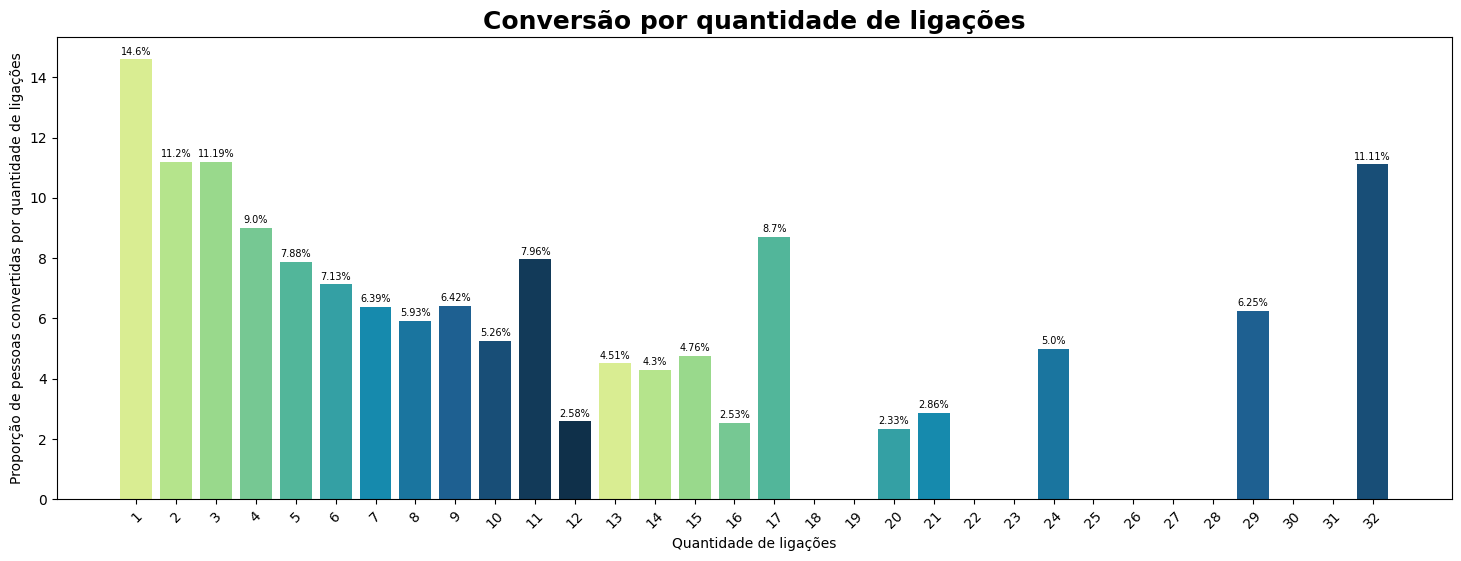

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))

bar_chart(
    campaign_converted["campaign"], 
    campaign_converted["proportion"], 
    "Conversão por quantidade de ligações", 
    "Quantidade de ligações",
    "Proporção de pessoas convertidas por quantidade de ligações",
    fmt="%",
    ax=ax
)

#####
**Convertidos por dias passados desde o último contato**

In [37]:
contacted_vs_not_contacted = pd.concat([pd.DataFrame(np.where(df["pdays"] == -1, "não contatados", "contatados"), columns=["contacted"]), df["y"]], axis=1)
contacted_vs_not_contacted_converted = features_freq_by_target(contacted_vs_not_contacted, "y", "contacted", target_condition="yes", sort_ascending=False)
display(contacted_vs_not_contacted_converted)

,contacted,proportion
2,contatados,23.071333
3,não contatados,9.157331


In [38]:
contacted_only = df["pdays"] != -1
pdays_quantiles = pd.qcut(df["pdays"][contacted_only], 4).apply(interval_presentation)
pdays_converted = features_freq_by_target(df, "y", pdays_quantiles, target_condition="yes", sort_ascending=False)
display(pdays_converted)

,pdays,proportion
4,1 a 133,36.084453
5,133 a 194,27.823961
6,327 a 871,14.417476
7,194 a 327,13.878143


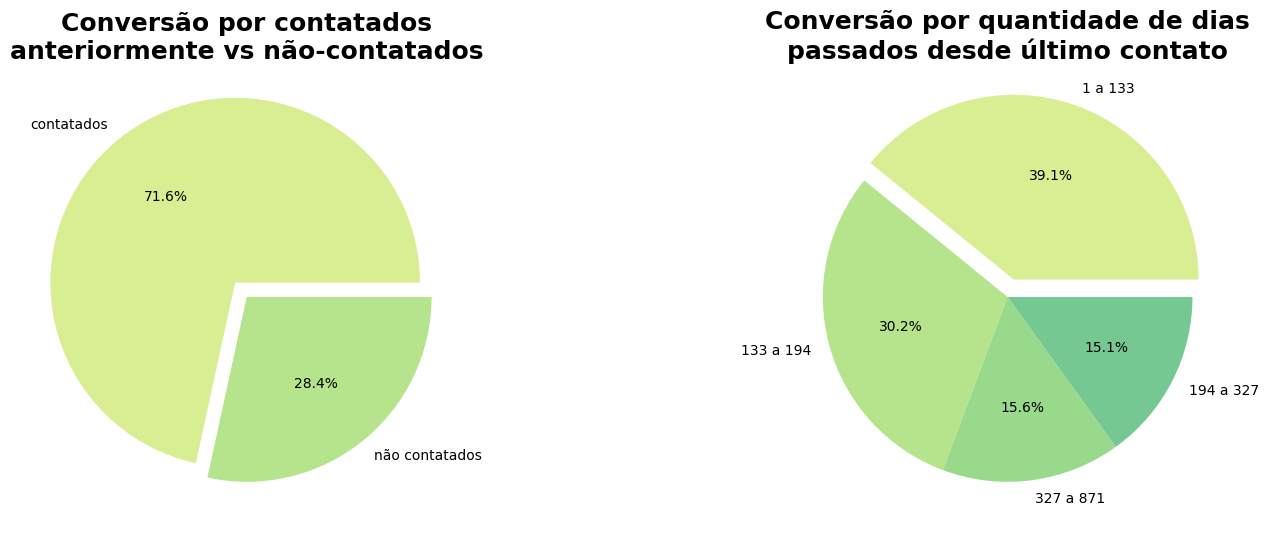

In [39]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

pie_chart(
    contacted_vs_not_contacted_converted["proportion"], 
    contacted_vs_not_contacted_converted["contacted"], 
    "Conversão por contatados\nanteriormente vs não-contatados",
    ax=ax1
)

pie_chart(
    pdays_converted["proportion"], 
    pdays_converted["pdays"], 
    "Conversão por quantidade de dias\npassados desde último contato",
    ax=ax2
)

#####
**Convertidos por quantidade de campanhas participadas**

In [40]:
previous_converted = features_freq_by_target(df, "y", "previous", target_condition="yes", normalize=True , sort_ascending=False).sort_values(by="previous")[:15]

# Descobrimos, utilizando o código abaixo e passando o parâmetro normalize=False na função anterior que
# a quantidade de campanhas ateriores relevantes para se analizar é de 0 a 14. Acima disso, os valores de
# contagem são insignificantes.

# count_5_or_higher = previous_converted["count"] >= 5
# previous_converted = previous_converted[count_5_or_higher]

display(previous_converted)

,previous,proportion
64,0,9.157331
58,1,21.031746
57,2,21.652422
50,3,25.744308
53,4,23.949580
46,5,26.361656
45,6,29.963899
47,7,26.341463
44,8,30.232558
49,9,26.086957


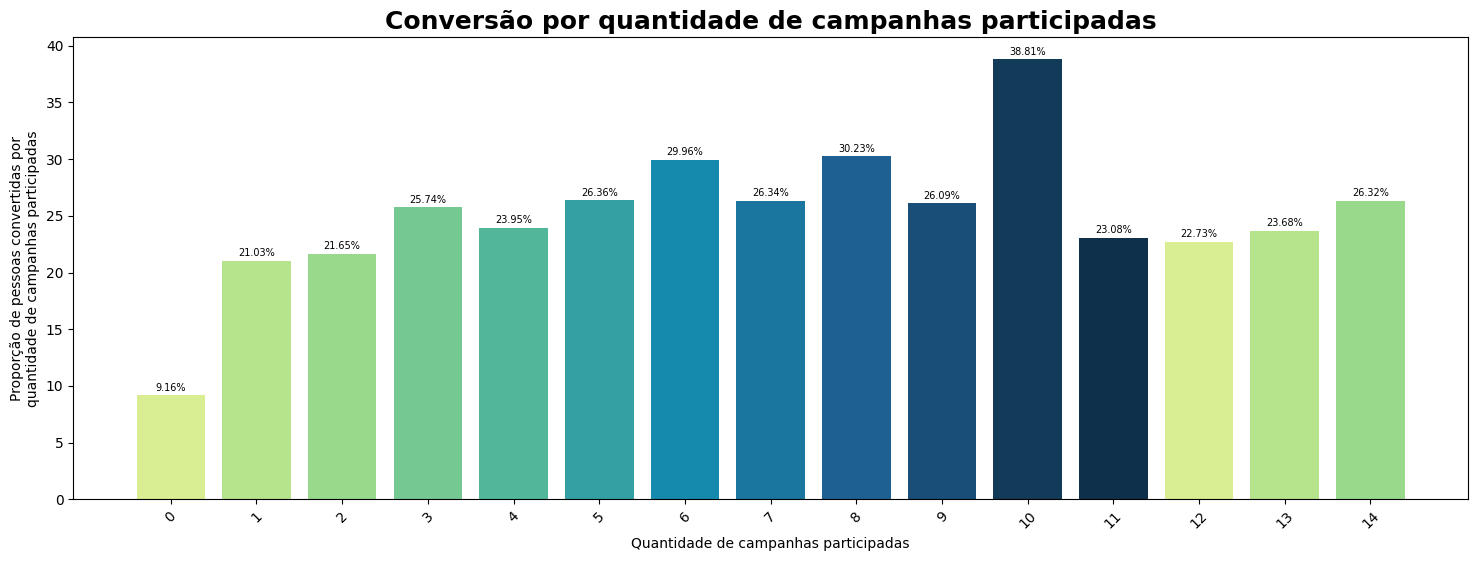

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))

bar_chart(
    previous_converted["previous"], 
    previous_converted["proportion"], 
    "Conversão por quantidade de campanhas participadas", 
    "Quantidade de campanhas participadas",
    "Proporção de pessoas convertidas por\nquantidade de campanhas participadas",
    fmt="%",
    ax=ax
)

#####
**Convertidos por resultados de últimas campanhas**

In [42]:
participated_on_previous = df[df["poutcome"] != "unknown"]
poutcome_converted = features_freq_by_target(participated_on_previous, "y", "poutcome", target_condition="yes", sort_ascending=False)
display(poutcome_converted)

,poutcome,proportion
2,success,64.725347
4,other,16.684783
5,failure,12.609671


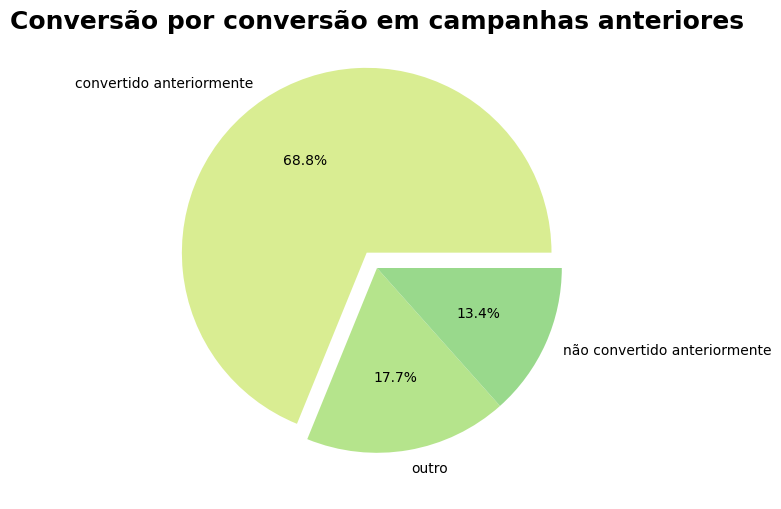

In [43]:
pie_chart(poutcome_converted["proportion"], ["convertido anteriormente", "outro", "não convertido anteriormente"], "Conversão por conversão em campanhas anteriores")

####
## Pre-processamento

In [44]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [45]:
df["default"].unique(), df["housing"].unique(), df["loan"].unique(), df["y"].unique()

(array(['no', 'yes'], dtype=object),
 array(['yes', 'no'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object))

In [46]:
df["default"] = np.where(df["default"] == "yes", 1, 0)
df["housing"] = np.where(df["housing"] == "yes", 1, 0)
df["loan"] = np.where(df["loan"] == "yes", 1, 0)
df["y"] = np.where(df["y"] == "yes", 1, 0)

In [47]:
df["education"].unique()

array(['tertiary', 'secondary', 'unknown', 'primary'], dtype=object)

In [48]:
df["education"] = np.where(df["education"] == "unknown", 0,
                           np.where(df["education"] == "primary", 1,
                                   np.where(df["education"] == "secondary", 2, 3)))

In [49]:
df["month"].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr', 'sep'], dtype=object)

In [50]:
months = {
    "jan": 0,
    "feb": 1,
    "mar": 2,
    "apr": 3,
    "may": 4,
    "jun": 5,
    "jul": 6,
    "aug": 7,
    "sep": 8,
    "oct": 9,
    "nov": 10,
    "dec": 11,
}

df["month"] = df["month"].apply(lambda month: months[month])

In [51]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,3,0,2143,1,0,unknown,5,4,261,1,-1,0,unknown,0
1,44,technician,single,2,0,29,1,0,unknown,5,4,151,1,-1,0,unknown,0
2,33,entrepreneur,married,2,0,2,1,1,unknown,5,4,76,1,-1,0,unknown,0
3,47,blue-collar,married,0,0,1506,1,0,unknown,5,4,92,1,-1,0,unknown,0
4,33,unknown,single,0,0,1,0,0,unknown,5,4,198,1,-1,0,unknown,0


In [52]:
X_with_dummies = pd.get_dummies(
    df,
    columns=["job", "marital", "contact", "poutcome"]
).drop("y", axis=1)

In [53]:
X_with_dummies.T

,0,1,2,3,4,5,6,7,8,9,...,45201,45202,45203,45204,45205,45206,45207,45208,45209,45210
age,58,44,33,47,33,35,28,42,58,43,...,53,34,23,73,25,51,71,72,57,37
education,3,2,2,0,0,3,3,3,1,2,...,3,2,3,2,2,3,1,2,2,2
default,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
balance,2143,29,2,1506,1,231,447,2,121,593,...,583,557,113,2850,505,825,1729,5715,668,2971
housing,1,1,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
loan,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
day,5,5,5,5,5,5,5,5,5,5,...,17,17,17,17,17,17,17,17,17,17
month,4,4,4,4,4,4,4,4,4,4,...,10,10,10,10,10,10,10,10,10,10
duration,261,151,76,92,198,139,217,380,50,55,...,226,224,266,300,386,977,456,1127,508,361
campaign,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,2,3,2,5,4,2


####
## Modelos

### Separação entre treino e teste

In [54]:
X = X_with_dummies
y = df["y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Modelo 1 - Regressão Logística

In [55]:
model_logreg = LogisticRegression(max_iter=1_000).fit(X_train, y_train)

In [56]:
y_pred = model_logreg.predict(X_test)

In [57]:
classification_metrics(y_test, y_pred)


    AVALIAÇÃO DO MODELO - MÉTRICAS DE CLASSIFICAÇÃO

    Acurácia:   0.8949424948392805
    Precisão:   0.6220028208744711
    Revocação:  0.2759699624530663
    F1-Score:   0.3823146944083225
    AUC:        0.6267865857727475
    


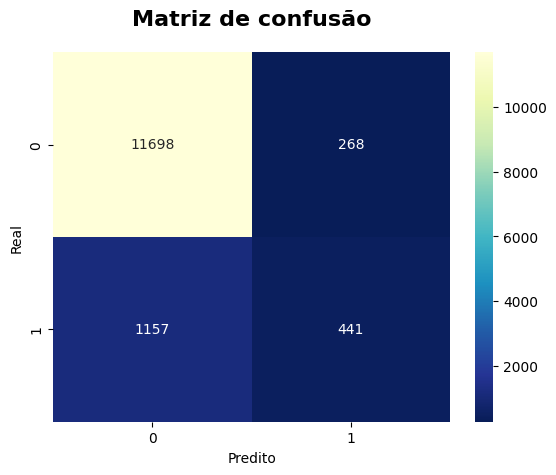

In [58]:
confusion_mtx(y_test, y_pred)

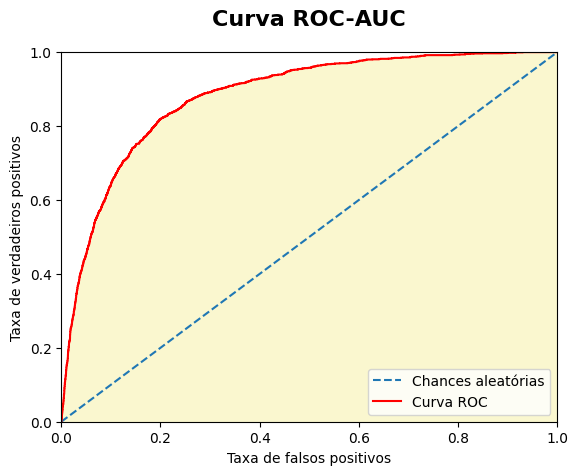

In [59]:
roc_auc(model_logreg, X_test, y_test, y_pred)

### Modelo 2 - Árvore de decisão

In [60]:
model_dectree = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

In [61]:
y_pred = model_dectree.predict(X_test)

In [62]:
classification_metrics(y_test, y_pred)


    AVALIAÇÃO DO MODELO - MÉTRICAS DE CLASSIFICAÇÃO

    Acurácia:   0.873267472721911
    Precisão:   0.4632665452337584
    Revocação:  0.47747183979974966
    F1-Score:   0.4702619414483821
    AUC:        0.7017979289254473
    


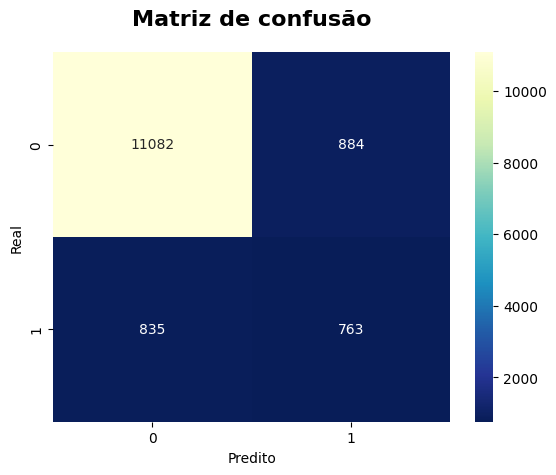

In [63]:
confusion_mtx(y_test, y_pred)

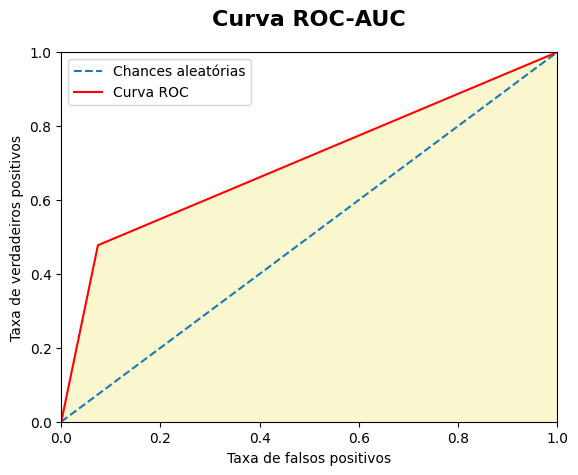

In [64]:
roc_auc(model_dectree, X_test, y_test, y_pred)

In [65]:
model_dectree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

#### Ajuste de hiperparâmetros por experimentação

In [66]:
model_dectreev2 = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=10,
    random_state=42,
).fit(X_train, y_train)

In [67]:
y_pred = model_dectreev2.predict(X_test)

In [68]:
classification_metrics(y_test, y_pred)


    AVALIAÇÃO DO MODELO - MÉTRICAS DE CLASSIFICAÇÃO

    Acurácia:   0.8936154526688292
    Precisão:   0.5547703180212014
    Revocação:  0.49123904881101377
    F1-Score:   0.5210753401924991
    AUC:        0.7192949380775777
    


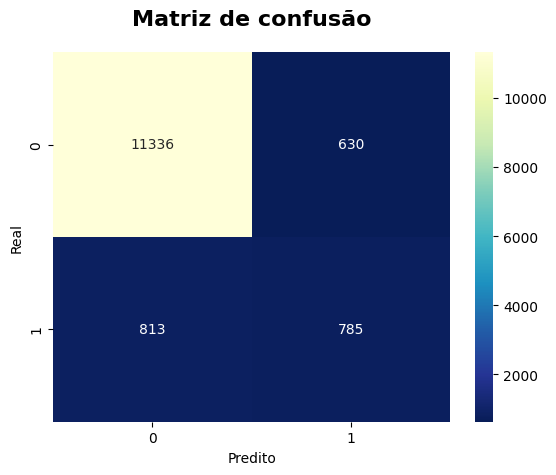

In [69]:
confusion_mtx(y_test, y_pred)

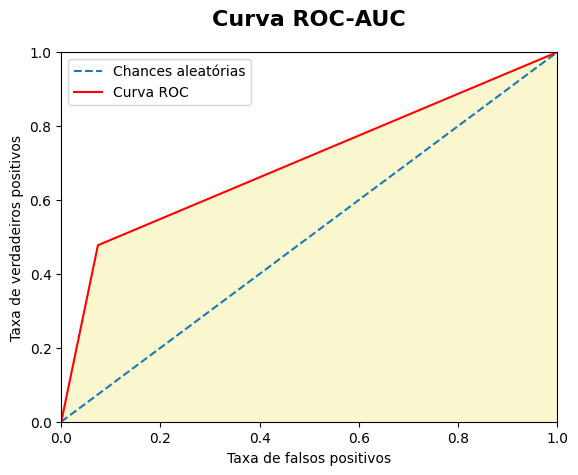

In [70]:
roc_auc(model_dectree, X_test, y_test, y_pred)

#### Ajuste de hiperparâmetros utilizando o GridSearch

In [65]:
model_gscv = DecisionTreeClassifier()

param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
    "max_leaf_nodes": [None, 10, 50, 100],
    "min_impurity_decrease": [0.0, 0.05, 0.1],
    "ccp_alpha": [0.0, 0.05, 0.1],
    "monotonic_cst": [None, -1, 0, 1]
}

In [66]:
grid_search = GridSearchCV(
    estimator=model_gscv,
    param_grid=param_grid,
    cv=2,
    verbose=1,
    n_jobs=-1
).fit(X_train, y_train)

Fitting 2 folds for each of 62208 candidates, totalling 124416 fits


In [67]:
print("Melhores parâmetros:\n", grid_search.best_params_)

Melhores parâmetros:
 {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'max_leaf_nodes': 100, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'monotonic_cst': None, 'splitter': 'best'}


In [68]:
print("Melhores parâmetros:\n", grid_search.best_score_)

Melhores parâmetros:
 0.897873374083892


In [69]:
best_model_dectree = grid_search.best_estimator_

In [70]:
y_pred = best_model_dectree.predict(X_test)

In [71]:
classification_metrics(y_test, y_pred)


    AVALIAÇÃO DO MODELO - MÉTRICAS DE CLASSIFICAÇÃO

    Acurácia:   0.893320554408729
    Precisão:   0.588098016336056
    Revocação:  0.31539424280350437
    F1-Score:   0.41059063136456214
    AUC:        0.6429469960465791
    


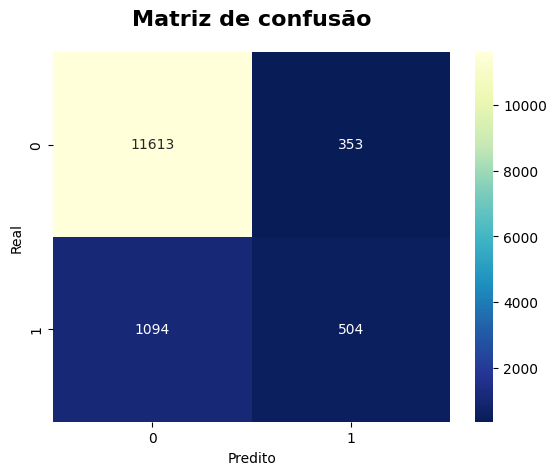

In [72]:
confusion_mtx(y_test, y_pred)

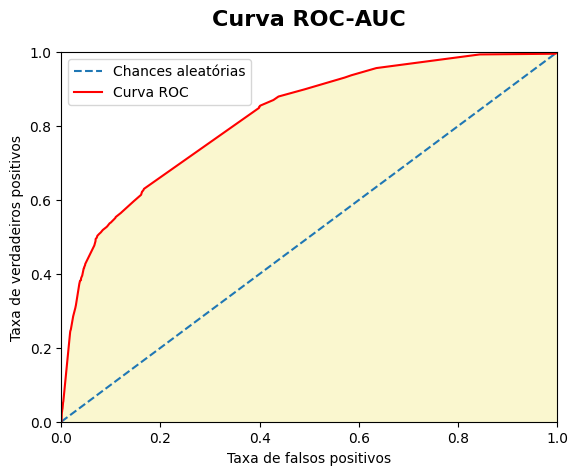

In [73]:
roc_auc(best_model_dectree, X_test, y_test, y_pred)

### Modelo 3 - Random Forest

In [74]:
model_randforest = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [75]:
y_pred = model_randforest.predict(X_test)

In [76]:
classification_metrics(y_test, y_pred)


    AVALIAÇÃO DO MODELO - MÉTRICAS DE CLASSIFICAÇÃO

    Acurácia:   0.9046004128575641
    Precisão:   0.6715575620767494
    Revocação:  0.3723404255319149
    F1-Score:   0.47906602254428343
    AUC:        0.6740107609859141
    


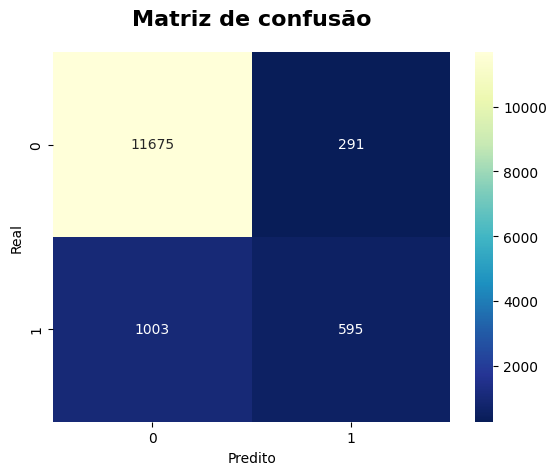

In [77]:
confusion_mtx(y_test, y_pred)

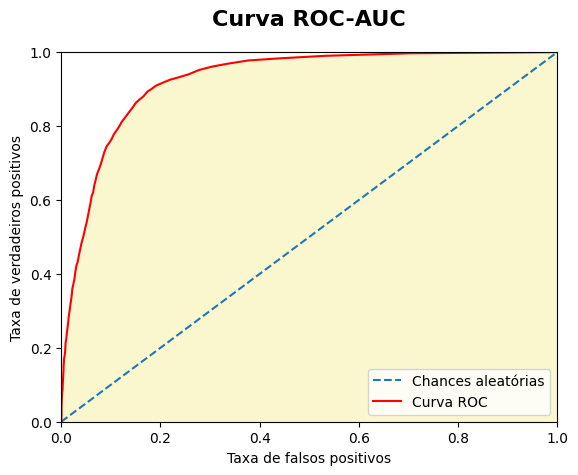

In [78]:
roc_auc(model_randforest, X_test, y_test, y_pred)

#### Ajuste de hiperparâmetros utilizando o GridSearch

In [79]:
model_gscv = RandomForestClassifier()

param_grid = {
    "n_estimators": [20, 100, 200],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
    "max_leaf_nodes": [None, 10, 50, 100],
    "min_impurity_decrease": [0.0, 0.05, 0.1],
    "ccp_alpha": [0.0, 0.05, 0.1],
    "monotonic_cst": [None, -1, 0, 1]
}

In [80]:
grid_search = GridSearchCV(
    estimator=model_gscv,
    param_grid=param_grid,
    cv=2,
    verbose=1,
    n_jobs=-1
).fit(X_train, y_train)

Fitting 2 folds for each of 93312 candidates, totalling 186624 fits


In [81]:
print("Melhores parâmetros:\n", grid_search.best_params_)

Melhores parâmetros:
 {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'monotonic_cst': None, 'n_estimators': 100}


In [82]:
print("Melhores parâmetros:\n", grid_search.best_score_)

Melhores parâmetros:
 0.9044143034032897


In [83]:
best_model_randtree = grid_search.best_estimator_

In [84]:
y_pred = best_model_dectree.predict(X_test)

In [85]:
classification_metrics(y_test, y_pred)


    AVALIAÇÃO DO MODELO - MÉTRICAS DE CLASSIFICAÇÃO

    Acurácia:   0.893320554408729
    Precisão:   0.588098016336056
    Revocação:  0.31539424280350437
    F1-Score:   0.41059063136456214
    AUC:        0.6429469960465791
    


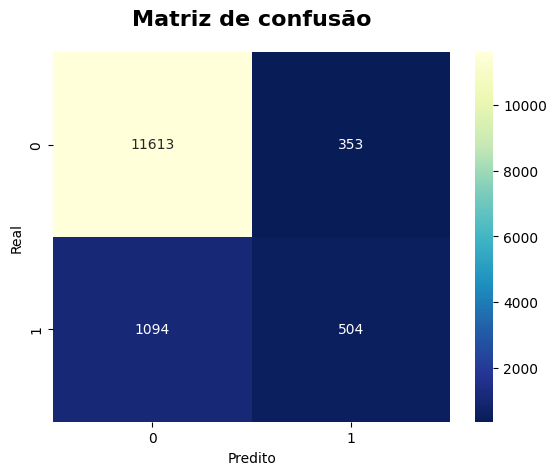

In [86]:
confusion_mtx(y_test, y_pred)

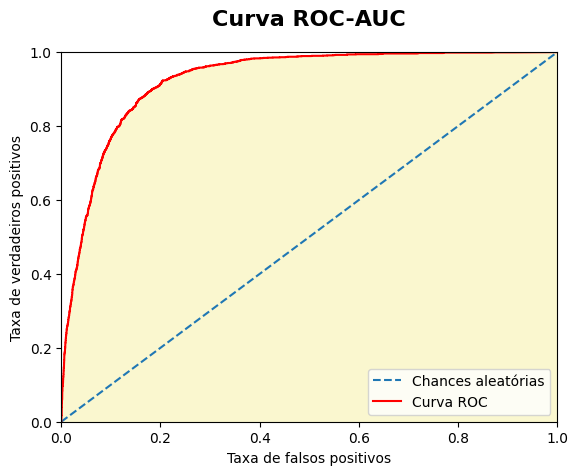

In [87]:
roc_auc(best_model_randtree, X_test, y_test, y_pred)

### Modelo 4 - KNN

In [83]:
model_knn = KNeighborsClassifier(n_neighbors=213).fit(X_train, y_train)

In [87]:
y_pred = model_knn.predict(X_test)

In [88]:
classification_metrics(y_test, y_pred)


    AVALIAÇÃO DO MODELO - MÉTRICAS DE CLASSIFICAÇÃO

    Acurácia:   0.8855057505160719
    Precisão:   0.5709779179810726
    Revocação:  0.1132665832290363
    F1-Score:   0.18903394255874673
    AUC:        0.5509505237722985
    


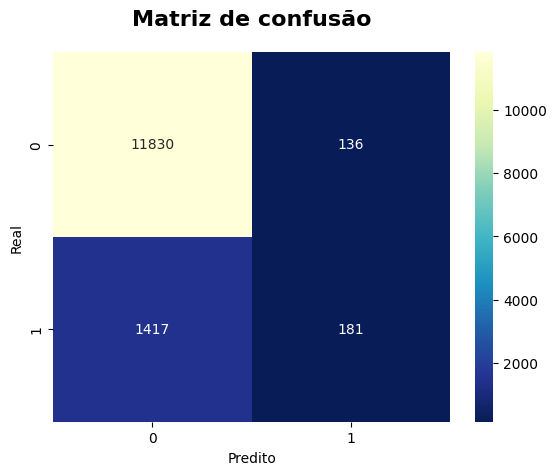

In [89]:
confusion_mtx(y_test, y_pred)

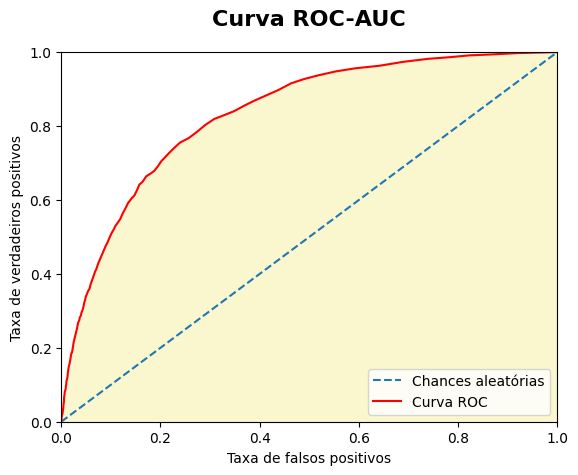

In [91]:
roc_auc(model_knn, X_test, y_test, y_pred)